In [20]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [21]:
heartData = pd.read_csv("heart-failure-prediction/heart.csv")
# Entfernen unangegebener Cholersterin Beobachtungen und Frauen
heartData = heartData[(heartData["Sex"] != "F") & (heartData["Cholesterol"] != 0)]
heartData = heartData.drop(columns=["ST_Slope" ,"RestingECG", "ChestPainType", "ExerciseAngina"])
heartData.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,M,140,289,0,172,0.0,0
2,37,M,130,283,0,98,0.0,0
4,54,M,150,195,0,122,0.0,0
5,39,M,120,339,0,170,0.0,0
7,54,M,110,208,0,142,0.0,0


In [22]:
#Entfernen von Cholesterin
q1 = heartData['Cholesterol'].quantile(0.25)
q3 = heartData['Cholesterol'].quantile(0.75)
iqr = q3-q1
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)
# trimming - delete the outlier data
new_df = heartData.loc[(heartData['Cholesterol'] <= upper_limit) & (heartData['Cholesterol'] >= lower_limit)]
heartData = new_df.copy()

# Entfernen von RestingBP
q1 = heartData['RestingBP'].quantile(0.25)
q3 = heartData['RestingBP'].quantile(0.75)
iqr = q3-q1
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)
# trimming - delete the outlier data
new_df = heartData.loc[(heartData['RestingBP'] <= upper_limit) & (heartData['RestingBP'] >= lower_limit)]
heartData = new_df.copy()

In [23]:
# Umwandlung der Spalte "Sex" in nummerischen Wert
heartData["Sex"] = heartData["Sex"].apply(lambda x: 0 if x == "M" else 1)

In [24]:
# Features und Zielvariable
X = heartData[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]
y = heartData['HeartDisease']

# Daten normalisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalisierte Daten und Zielvariable zusammenfügen
heartData = pd.DataFrame(X_scaled, columns=['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'])
heartData['HeartDisease'] = y.values

In [25]:
# Lineare Regression mit statsmodels
model = smf.ols('HeartDisease ~ Age + RestingBP + Cholesterol + FastingBS + MaxHR + Oldpeak', data=heartData)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           HeartDisease   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     48.75
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.16e-47
Time:                        20:27:07   Log-Likelihood:                -268.85
No. Observations:                 538   AIC:                             551.7
Df Residuals:                     531   BIC:                             581.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5576      0.017     32.218      

0.40284356001712557
0.3210736518863405


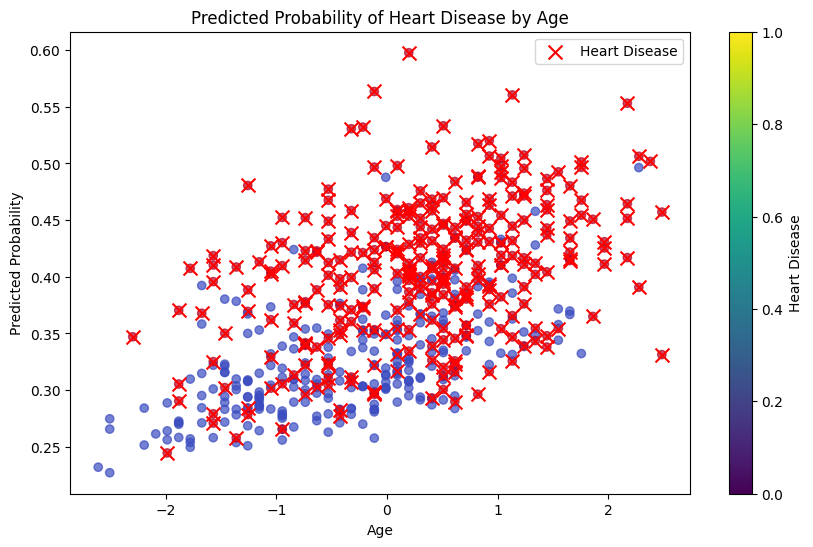

In [26]:
def predHD(Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak):
    predHD = (Age * 0.0469 + RestingBP * (-0.0073) + Cholesterol * 0.0368 + 
              FastingBS * 0.0333 + MaxHR * (-0.1291) + Oldpeak * 0.1991 - 0.5576)
    return 1 / (1 + np.exp(-predHD))

# Beispiel-Daten
df = heartData.copy()

# Vorhersage der Wahrscheinlichkeiten für jede Zeile im DataFrame
df['predicted_prob'] = df.apply(lambda row: predHD(row['Age'], row['RestingBP'], row['Cholesterol'], row['FastingBS'], row['MaxHR'], row['Oldpeak']), axis=1)

# Trennung der Daten nach Herzkrankheit und keiner Herzkrankheit
hd = df[df['HeartDisease'] == 1]
nd = df[df['HeartDisease'] == 0]

print(hd["predicted_prob"].mean())
print(nd["predicted_prob"].mean())

# Visualisierung der vorhergesagten Wahrscheinlichkeiten gegen das Alter
plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], df['predicted_prob'], c=df['HeartDisease'], cmap='coolwarm', alpha=0.7)
plt.scatter(hd['Age'], hd['predicted_prob'], c='red', marker='x', s=100, label='Heart Disease')
plt.colorbar(label='Heart Disease')
plt.xlabel('Age')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of Heart Disease by Age')
plt.legend()
plt.show()

LogisticRegression()
Best parameters: {'C': 0.1}
0.7031163078291458
0.35869677855706883


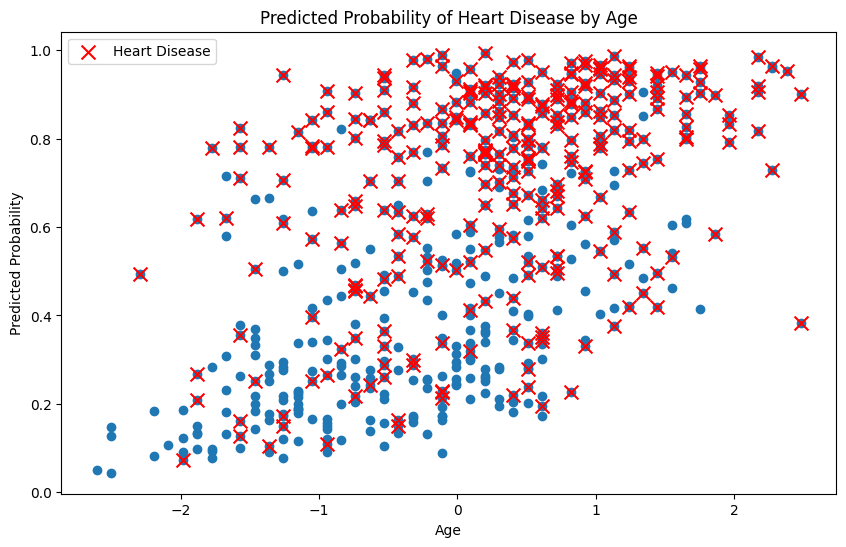

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# Features und Zielvariable
X = heartData[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]
y = heartData['HeartDisease']

# Daten aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistische Regression mit Hyperparameter-Tuning
logreg = LogisticRegression()
param_grid = {'C': [0.1, 1, 10, 100]}
kf = KFold(n_splits=3)  # Kleinere Anzahl von Splits verwenden

grid_search = GridSearchCV(logreg, param_grid, cv=kf, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

# Beste Parameter und Modell
print(f"Best parameters: {grid_search.best_params_}")
best_logreg = grid_search.best_estimator_

# Vorhersagen und Wahrscheinlichkeiten berechnen
y_pred = best_logreg.predict(X_test_scaled)
y_pred_prob = best_logreg.predict_proba(X_test_scaled)[:, 1]

# Visualisieren der vorhergesagten Wahrscheinlichkeiten gegen das Alter
heartData['predicted_prob'] = best_logreg.predict_proba(scaler.transform(X))[:, 1]
hd = heartData[heartData['HeartDisease'] == 1]
nd = heartData[heartData['HeartDisease'] == 0]
print(hd["predicted_prob"].mean())
print(nd["predicted_prob"].mean())

plt.figure(figsize=(10, 6))
plt.scatter(heartData['Age'], heartData['predicted_prob'])
plt.scatter(hd['Age'], hd['predicted_prob'], c='red', marker='x', s=100, label='Heart Disease')
plt.xlabel('Age')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of Heart Disease by Age')
plt.legend()
plt.show()
